In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

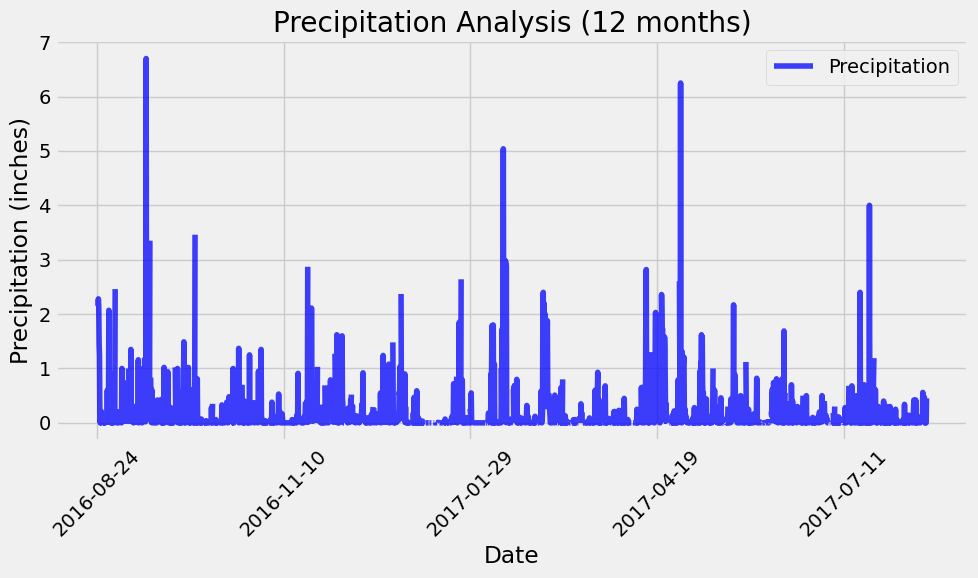

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
#one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1).strftime('%Y-%m-%d')
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind='line', figsize=(10,6), color='b', alpha=0.75, rot=45)
plt.title("Precipitation Analysis (12 months)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
most_active_station_name = session.query(Station.name).filter_by(station=most_active_station).scalar()
print(f"The most active station is {most_active_station} - {most_active_station_name} with {most_active_stations[0][1]} observations.")
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()

print(f"Lowest Temperature: {temperature_stats[0][0]} F")
print(f"Highest Temperature: {temperature_stats[0][1]} F")
print(f"Average Temperature: {temperature_stats[0][2]} F")

The most active station is USC00519281 - WAIHEE 837.5, HI US with 2772 observations.
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


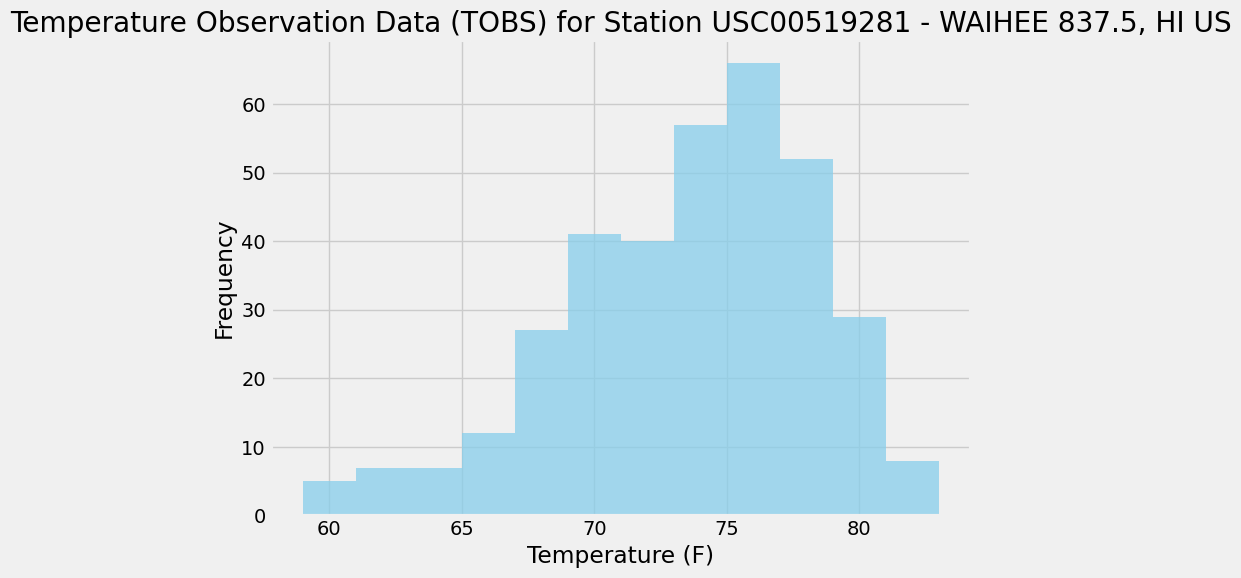

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.date >= one_year_ago).\
            filter(Measurement.station == most_active_station).all()
tobs_df = pd.DataFrame(tobs_data, columns=['Temperature'])
# Plot the results as a histogram
plt.figure(figsize=(8,6))
plt.hist(tobs_df['Temperature'], bins=12, color='skyblue', alpha=0.75)
plt.title(f"Temperature Observation Data (TOBS) for Station {most_active_station} - {most_active_station_name}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()